In [1]:
import drjit as dr
import mitsuba as mi


In [2]:
mi.set_variant('scalar_spectral_polarized')
from mitsuba import ScalarTransform4f as T


In [3]:
scene = mi.load_dict({
    'type': 'scene',
    'integrator': {
        'type': 'stokes',
        'integrator': {
            'type': 'path'
        }
    },
    'sensor':  {
        'type': 'perspective',
        'to_world': T.look_at(
                        origin=(0, 0, 2),
                        target=(0, 0, 0),
                        up=(0, 1, 0)
                    ),
        'fov': 45,
        'film': {
            'type': 'hdrfilm',
            'width': 360,
            'height': 360,
            'rfilter': { 'type': 'gaussian' },
            'sample_border': True
        },
    },
    'wall': {
        'type': 'obj',
        'filename': '/scenes/meshes/rectangle.obj',
        'to_world': T.translate([0, 0, 0]).scale(2.0),
        'bsdf': {
            'type': 'dielectric',
            'int_ior': 1.5,
            'ext_ior': 1.0
        }
    },
    'bunny': {
        'type': 'ply',
        'filename': '/scenes/meshes/bunny.ply',
        'to_world': T.translate([0, 0, -2]).scale(6.5),
        'bsdf': {
            'type': 'dielectric',
            'int_ior': 1.5,
            'ext_ior': 1.0,
            # 'specular_reflectance': {'type': 'rgb', 'value': (0.5, 0.1, 0.1)}, 
            # 'specular_transmittance': {'type': 'rgb', 'value': (0.5, 0.1, 0.1)}
        },
    },
    # 'light': {
    #     'type': 'obj',
    #     'filename': '/scenes/meshes/sphere.obj',
    #     'emitter': {
    #         'type': 'area',
    #         'radiance': {'type': 'rgb', 'value': [1e3, 1e3, 1e3]}
    #     },
    #     'to_world': T.translate([2.5, 2.5, 7.0]).scale(0.25)
    # }
    'light': {'type': 'constant'},
    # 'light': {
    #     'type': 'projector',
    #     'fov': 179,
    #     'irradiance': {
    #         'type': 'rgb',
    #         'value': [1e3, 1e3, 1e3]
    #     },
    #     'to_world': T.look_at(
    #         origin=[0, 0.1, 2],
    #         target=[0, 0, 0],
    #         up=[0, 1, 0]
    #     )
    # }
})

2024-05-27 19:39:01 WARN main [Mesh] "bunny.ply": computed vertex normals (1113 invalid vertices!)

In [4]:
img_ref = mi.render(scene, spp=4096)
img_ref

TensorXf(shape=(360, 360, 15))

In [5]:
bitmap = mi.Bitmap(img_ref, channel_names=['R', 'G', 'B'] + scene.integrator().aov_names())
bitmap.write('cbox_pol_output.exr')
bitmap

Bitmap[
  pixel_format = multichannel,
  component_format = float32,
  size = [360, 360],
  srgb_gamma = 0,
  struct = Struct<60>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
    float32 S0.R; // @12, premultiplied alpha
    float32 S0.G; // @16, premultiplied alpha
    float32 S0.B; // @20, premultiplied alpha
    float32 S1.R; // @24, premultiplied alpha
    float32 S1.G; // @28, premultiplied alpha
    float32 S1.B; // @32, premultiplied alpha
    float32 S2.R; // @36, premultiplied alpha
    float32 S2.G; // @40, premultiplied alpha
    float32 S2.B; // @44, premultiplied alpha
    float32 S3.R; // @48, premultiplied alpha
    float32 S3.G; // @52, premultiplied alpha
    float32 S3.B; // @56, premultiplied alpha
  ],
  data = [ 7.42 MiB of image data ]
]

In [6]:
channels = dict(bitmap.split())
print(channels.keys())

dict_keys(['<root>', 'S0', 'S1', 'S2', 'S3'])


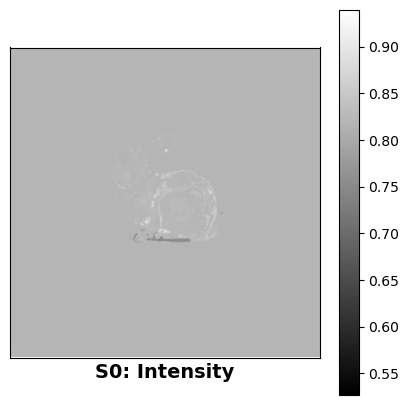

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.imshow(channels['S0'].convert(srgb_gamma=True), cmap='gray')
plt.colorbar()
plt.xticks([]); plt.yticks([])
plt.xlabel("S0: Intensity", size=14, weight='bold')
plt.savefig('s0_intensity_image_only.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

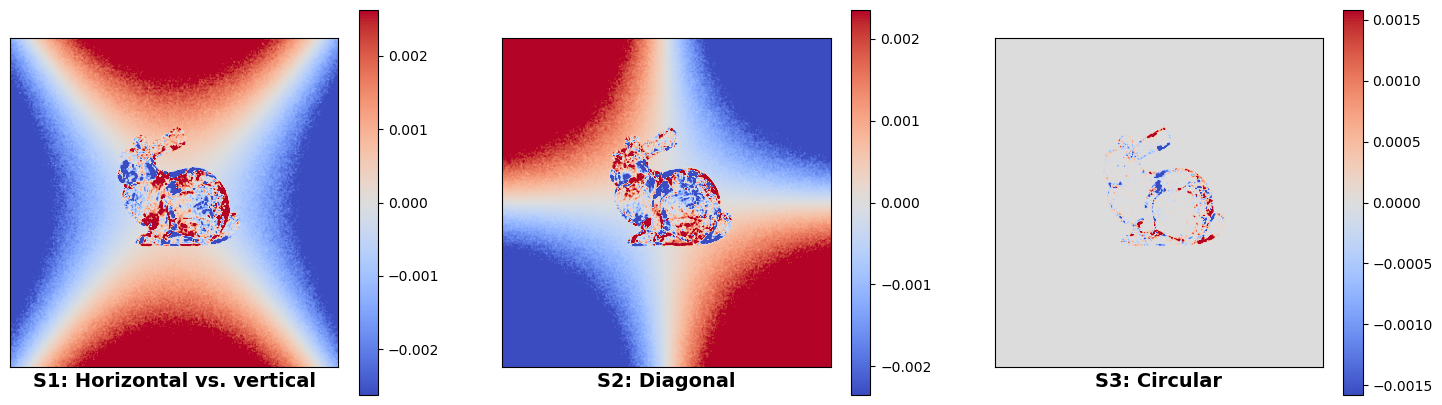

In [9]:
def plot_stokes_component(ax, image):
    # Convert the image into a TensorXf for manipulation
    data = mi.TensorXf(image)[:, :, 0]
    plot_minmax = 0.05 * max(dr.max(data), dr.max(-data)) # Arbitrary scale for colormap
    img = ax.imshow(data, cmap='coolwarm', vmin=-plot_minmax, vmax=+plot_minmax)
    ax.set_xticks([]); ax.set_yticks([])
    return img


fig, ax = plt.subplots(ncols=3, figsize=(18, 5))
img = plot_stokes_component(ax[0], channels['S1'])
plt.colorbar(img, ax=ax[0])
img = plot_stokes_component(ax[1], channels['S2'])
plt.colorbar(img, ax=ax[1])
img = plot_stokes_component(ax[2], channels['S3'])
plt.colorbar(img, ax=ax[2])
 
ax[0].set_xlabel("S1: Horizontal vs. vertical", size=14, weight='bold')
ax[1].set_xlabel("S2: Diagonal", size=14, weight='bold')
ax[2].set_xlabel("S3: Circular", size=14, weight='bold')

plt.show()